## Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [18, 10]
import numpy as np
import pandas as pd
from scipy import optimize
import numba as nb

## Data Prep

In [2]:
# 1 - Download VIX Index Data from CBOE
# 2 - Sort data by date
# 3 - Compute changes in the logarithm of 
DATA_URL = 'http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixcurrent.csv'

d_log_vix = (pd.read_csv(DATA_URL,
                         header=1,
                         index_col='Date',
                         parse_dates=['Date'],
                         usecols=['Date', 'VIX Close'])
             .sort_index()
             .assign(ret=lambda df: np.log(df['VIX Close']).diff())
             .drop('VIX Close', 1)
             .dropna()
             .rename_axis('date'))

d_log_vix_arr = d_log_vix.values[:, 0] # As 1-d Numpy array

### ARMA(1,1)
A zero-mean timeseries $z_t$ is modeled as a mean-reverting $ARMA(1,1)$ process. It follows that $z_t$ is given by:
$$z_t = \varphi \cdot z_{t-1} + \varepsilon_t + \theta \cdot \varepsilon_{t-1}$$

The $AR(\infty)$ form of the above process can be written in the form:
$$\varepsilon_t = z_t + \beta (1-\gamma) \sum_{i=1}^{\infty} \gamma^i z_{t-i}$$

where, $$\gamma=-\theta$$ and $$\beta=\frac{\phi+\theta}{1+\theta}< 0$$

So that, $z_t$ can be thought of as being forecasted by $\beta$ (a scaling term) times the exponentially weighted moving average of its lags.

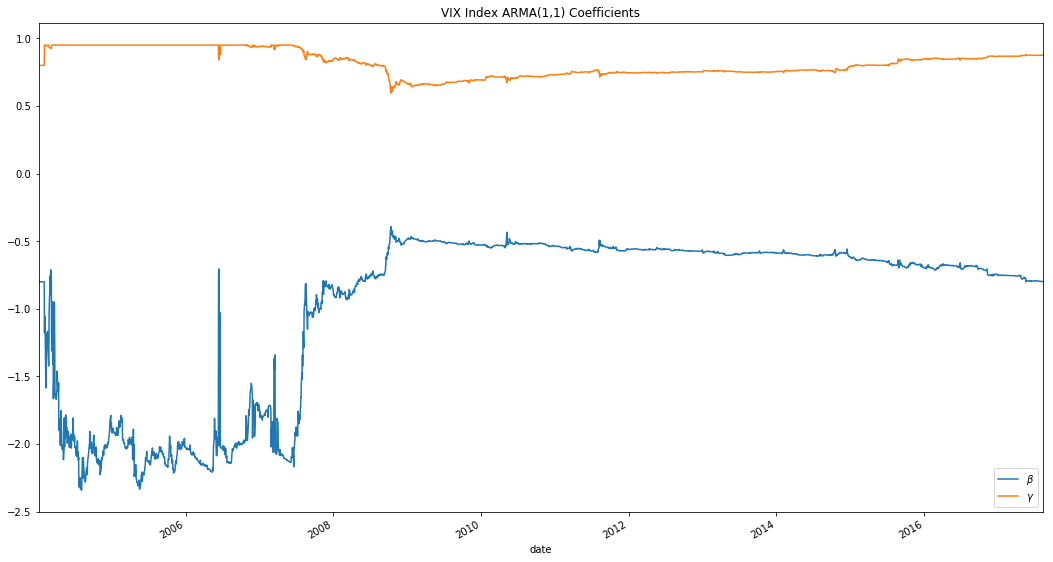

In [3]:
_X0 = np.r_[0.8, 0.8]
_FEASIBLE_PARAMS = [(0.5, 0.95), (0.1, 0.95)]

@nb.jit
def forecast(params, z):
    T = z.shape[0]
    _g, _u = params
    _ema = np.zeros((T,))
    _ema[0] = (1 - _g) * z[0]
    for t in range(1, T):
        _ema[t] = _g * _ema[t - 1] + (1 - _g) * z[t]
    _b = _g * (_u - 1) / (1 - _g)
    return _b * _ema

@nb.jit
def score(params, z):
    _forecast = forecast(params, z)
    _err = (np.square(z[1:] - _forecast[:-1])).sum()
    return _err

def fit(z, x0=_X0, bounds=_FEASIBLE_PARAMS):
    optim = optimize.minimize(fun=score, x0=x0, args=z, method='l-bfgs-b', bounds=bounds)
    return optim['x']

def expanding_fit(z):
    T = z.shape[0]
    MIN_PERIODS = 20
    _fits = np.zeros((T, 2))
    _fits[0:MIN_PERIODS,:] = _X0.T
    for t in range(MIN_PERIODS, T):
        _fits[t,:] = fit(z=z[0:t], x0=_fits[t-1,:])
    return _fits

def test_expanding_fit(df):
    g, u = np.split(expanding_fit(df.values[:, 0]), 2, 1)
    g, u = g.reshape((-1)), u.reshape((-1))
    ar, ma = (g * u), -g
    beta = g * (u - 1) / (1 - g)
    fits = pd.DataFrame(data={r'$\gamma$':g, r'$\beta$':beta}, index = df.index)
    return fits

coefficients = test_expanding_fit(df=d_log_vix)

coefficients.plot(title='VIX Index ARMA(1,1) Coefficients')